In [4]:
# load some packages
from matplotlib.text import Text
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from ripser import ripser
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import oat_python as oat

In [5]:
dfphymath = pd.read_csv(
        'https://www.dropbox.com/scl/fi/62eki84qj8cynzgpa4a77/concepts_Mathematical-Physics_105.csv.gz?rlkey=uyppmch667rgl63vzh6tqxbxb&st=5o7q6nr0&dl=1',
        compression='gzip',
)


In [6]:
#bettimatrix

import networkx as nx
import pandas as pd
import numpy as np
import oat_python as oat

# config
MIN_RELEVANCE = 0.7
MIN_YEAR = 1920
MAX_YEAR = 2021  # when the data is from
MIN_CONCEPT_FREQ = 0.0001
MAX_CONCEPT_FREQ = 0.001
YEARS_GRID = np.linspace(0, 1, 100)
INV_COUNTS_GRID = np.linspace(0, 1, 40)
max_dim = 1
years_grid = np.linspace(0, 1, 100)
inv_counts_grid = np.linspace(0, 1, 40)

def dataprocess(df):
    df = df[df['relevance_mean'] >= MIN_RELEVANCE]
    df = df[df['year'] >= MIN_YEAR]
    num_articles = df['article_id'].nunique()
    concept_freq = df.groupby('concept').transform('size') / num_articles
    df = df[(concept_freq >= MIN_CONCEPT_FREQ) & (concept_freq <= MAX_CONCEPT_FREQ)]
    df = df[['article_id', 'concept', 'year']]

    return(df)

def conceptprocess(df):
    concepts = (
            df
                .sort_values('year')  # sort so earliest year is first
                .groupby('concept')
                .agg(
                    year=('year', 'min'),
                    count=('article_id', 'nunique')
                )
                .reset_index()
        )

    # normalize the year
    concepts['norm_year'] = (concepts['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
    concepts['inv_count'] = 1 / concepts['count']
    return(concepts)

def edgeprocess(df):
    edges = df.merge(df, on=['article_id', 'year'], suffixes=['_source', '_target'])
    edges = edges[edges['concept_source'] < edges['concept_target']]
    edges = edges.groupby(['concept_source', 'concept_target']).agg(
            year=('year', 'min'),
            count=('article_id', 'nunique')
        ).reset_index()

    edges['norm_year'] = (edges['year'] - MIN_YEAR) / (MAX_YEAR - MIN_YEAR)
    edges['inv_count'] = 1 / edges['count']
    return(edges)

def graphprocess(concepts,edges):
    G = nx.Graph()
    G.add_nodes_from([(c, {'norm_year': ny, 'inv_count': ic}) for c, ny, ic in zip(concepts['concept'], concepts['norm_year'], concepts['inv_count'])])
    G.add_edges_from([(u, v, {'norm_year': ny, 'inv_count': ic}) for u, v, ny, ic in zip(edges['concept_source'], edges['concept_target'], edges['norm_year'], edges['inv_count'])])
    
    return(G)

def processbetticurve(G):
    adj_year = nx.adjacency_matrix(G, weight='norm_year')
    adj_year.setdiag([d['norm_year'] for _, d in G.nodes(data=True)])
    adj_inv_count = nx.adjacency_matrix(G, weight='inv_count')
    adj_inv_count.setdiag([d['inv_count'] for _, d in G.nodes(data=True)])
    adj_year = adj_year.sorted_indices()
    betti_curves = np.empty((len(years_grid), len(inv_counts_grid), max_dim + 1))

    return betti_curves

def runcrocker(G, years_grid, inv_counts_grid):
    adj_year = nx.adjacency_matrix(G, weight='norm_year')
    adj_year.setdiag([d['norm_year'] for _, d in G.nodes(data=True)])
    adj_inv_count = nx.adjacency_matrix(G, weight='inv_count')
    adj_inv_count.setdiag([d['inv_count'] for _, d in G.nodes(data=True)])
    adj_year = adj_year.sorted_indices()

    betti_curves = np.empty((len(years_grid), len(inv_counts_grid), max_dim + 1))

    for i, c in enumerate(inv_counts_grid):
        c_adj = adj_year.copy()
        c_adj[adj_inv_count > c] = 0
        c_adj.eliminate_zeros()

        c_adj.setdiag([d['norm_year'] for _, d in G.nodes(data=True)])
        c_adj = c_adj.sorted_indices()

        if c_adj.nnz == 0 or c_adj.shape[0] == 0:
            for d in range(max_dim + 1):
                betti_curves[:, i, d] = 0
            continue

        try:
            factored = oat.rust.FactoredBoundaryMatrixVr(c_adj, max_dim)
            homology = factored.homology(False, False)

            for d in range(max_dim + 1):
                dim_homology = homology[homology['dimension'] == d]
                betti_curves[:, i, d] = ((dim_homology['birth'].values <= years_grid[:, None]) &
                                        (dim_homology['death'].values > years_grid[:, None])).sum(axis=1)
        except Exception as e:
            print(f"OAT error at inv_count={c:.3f}: {e}")
            for d in range(max_dim + 1):
                betti_curves[:, i, d] = 0

    return betti_curves

def mainfunc(df, years_grid, inv_counts_grid):
    df = dataprocess(df)
    concepts = conceptprocess(df)
    edges = edgeprocess(df)
    G = graphprocess(concepts, edges)
    betti_curves = runcrocker(G, years_grid, inv_counts_grid)
    return betti_curves

betti = mainfunc(dfphymath,YEARS_GRID,INV_COUNTS_GRID)
betti

array([[[    0.,     0.],
        [    0.,     0.],
        [    0.,     0.],
        ...,
        [    0.,     0.],
        [    0.,     0.],
        [    0.,     0.]],

       [[    0.,     0.],
        [    0.,     0.],
        [    0.,     0.],
        ...,
        [    0.,     0.],
        [    0.,     0.],
        [    0.,     0.]],

       [[    0.,     0.],
        [    0.,     0.],
        [    0.,     0.],
        ...,
        [    0.,     0.],
        [    0.,     0.],
        [    0.,     0.]],

       ...,

       [[15400.,     0.],
        [15400.,     0.],
        [15400.,     0.],
        ...,
        [14866.,     0.],
        [14866.,     0.],
        [ 3648.,   400.]],

       [[16762.,     0.],
        [16762.,     0.],
        [16762.,     0.],
        ...,
        [16209.,     0.],
        [16209.,     0.],
        [ 3783.,   518.]],

       [[18502.,     0.],
        [18502.,     0.],
        [18502.,     0.],
        ...,
        [17934.,     0.],
        [17934.

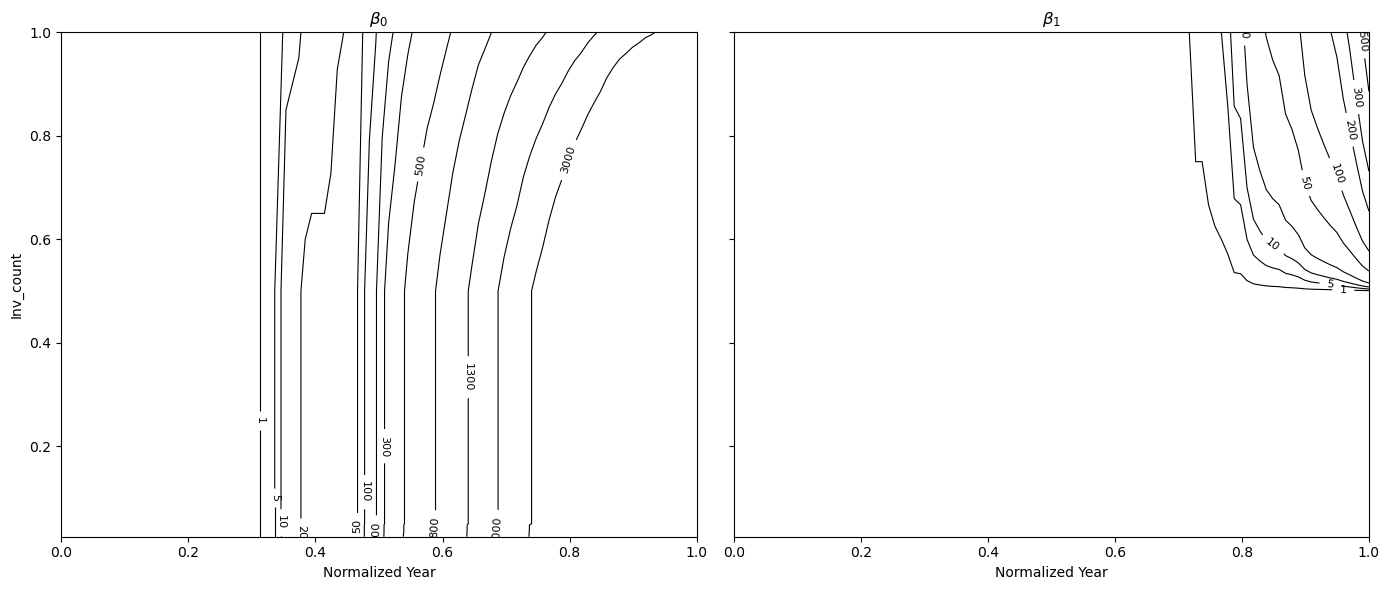

In [7]:
years = vals = np.linspace(0, 1, 100).tolist()
inv_counts = vals = 1 / np.arange(40, 0, -1)
X, Y = np.meshgrid(years, inv_counts)
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for dim, ax in enumerate(axs):
    Z = betti[:, :, dim].T
    cp = ax.contour(X, Y, Z, levels=[1, 5, 10, 20, 50, 100, 200,300,500,800,1300,2000,3000], colors='black', linewidths=0.8)
    ax.clabel(cp, inline=True, fontsize=8)
    ax.set_xlabel("Normalized Year")
    ax.set_title(f"$\\beta_{dim}$")

axs[0].set_ylabel("Inv_count")
plt.tight_layout()
plt.show()

In [8]:
def runcrocker2(G):
    adj_year = nx.adjacency_matrix(G, weight='norm_year')
    adj_year.setdiag([d['norm_year'] for _, d in G.nodes(data=True)])
    adj_inv_count = nx.adjacency_matrix(G, weight='inv_count')
    adj_inv_count.setdiag([d['inv_count'] for _, d in G.nodes(data=True)])
    adj_inv_count = adj_inv_count.sorted_indices()

    # run crocker
    years = np.unique(adj_year.data)
    inv_counts = np.unique(adj_inv_count.data)
    betti_curves = np.empty((len(years), len(inv_counts), max_dim + 1))

    for i, y in enumerate(years):
        # zero out things not included
        y_adj = adj_inv_count.copy()
        y_adj[adj_year > y] = 0
        y_adj.eliminate_zeros()

        # calcaulte homology
        factored = oat.rust.FactoredBoundaryMatrixVr(y_adj, max_dim)
        homology = factored.homology(False, False)

        # create betti curve
        for d in range(max_dim + 1):
            dim_homology = homology[homology['dimension'] == d]  # get teh right dimensional features
            betti_curves[i, :, d] = ((dim_homology['birth'].values <= inv_counts[:, None]) &
                                    (dim_homology['death'].values > inv_counts[:, None])).sum(axis=1)
    X, Y = np.meshgrid(years, inv_counts)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for dim, ax in enumerate(axs):
        Z = betti_curves[:, :, dim].T
        cp = ax.contour(X, Y, Z, levels=[1, 5, 10, 20, 50, 100, 200,300,500,800,1300,2000,3000], colors='black', linewidths=0.8)
        ax.clabel(cp, inline=True, fontsize=8)
        ax.set_xlabel("Normalized Year")
        ax.set_title(f"$\\beta_{dim}$")

    axs[0].set_ylabel("Inv_count")
    plt.tight_layout()
    plt.show()

    return betti_curves

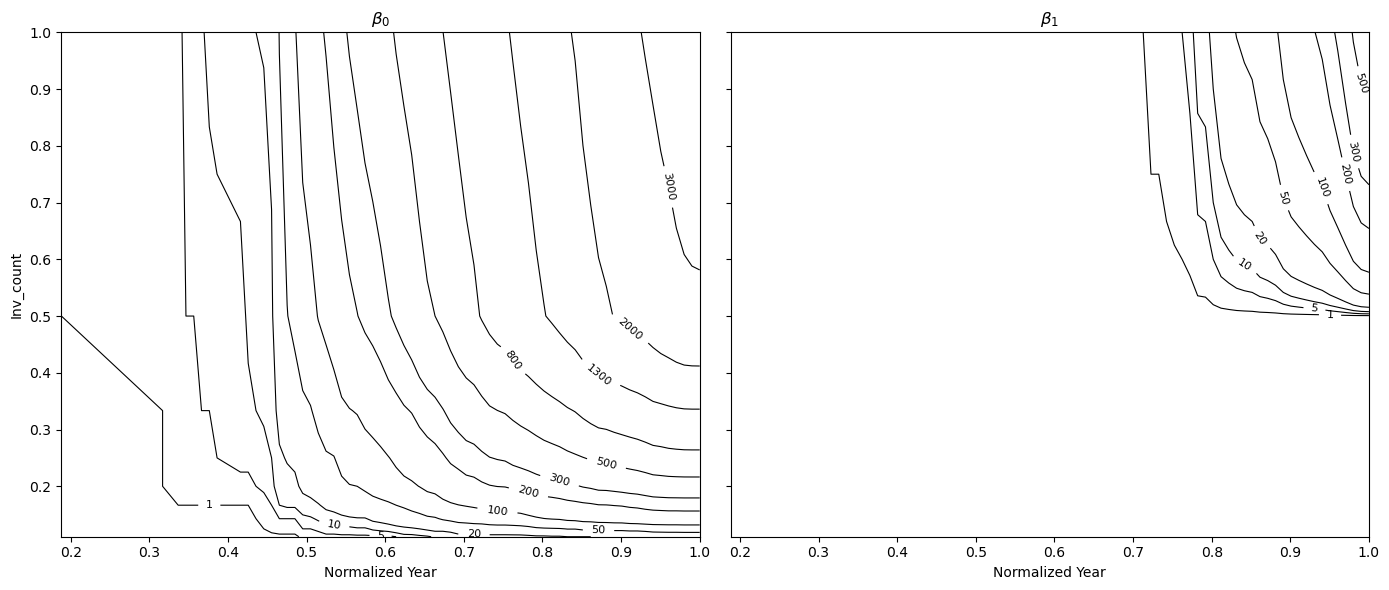

array([[[0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00],
        ...,
        [1.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00]],

       [[0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00],
        ...,
        [1.000e+00, 0.000e+00],
        [2.000e+00, 0.000e+00],
        [2.000e+00, 0.000e+00]],

       [[0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00],
        [1.000e+00, 0.000e+00],
        ...,
        [4.000e+00, 0.000e+00],
        [5.000e+00, 0.000e+00],
        [3.000e+00, 0.000e+00]],

       ...,

       [[2.800e+01, 0.000e+00],
        [6.800e+01, 0.000e+00],
        [1.510e+02, 0.000e+00],
        ...,
        [1.272e+03, 0.000e+00],
        [2.783e+03, 0.000e+00],
        [3.783e+03, 5.180e+02]],

       [[2.800e+01, 0.000e+00],
        [6.800e+01, 0.000e+00],
        [1.510e+02, 0.000e+00],
        ...,
        [1.276e+03, 0.000e+00],
        [2.806e+03

In [9]:
def mainfunc2(df):
    df = dataprocess(df)
    concepts = conceptprocess(df)
    edges = edgeprocess(df)
    G = graphprocess(concepts, edges)
    return G

G2 = mainfunc2(dfphymath)

betti2 = runcrocker2(G2)
betti2

In [11]:
betti

array([[[    0.,     0.],
        [    0.,     0.],
        [    0.,     0.],
        ...,
        [    0.,     0.],
        [    0.,     0.],
        [    0.,     0.]],

       [[    0.,     0.],
        [    0.,     0.],
        [    0.,     0.],
        ...,
        [    0.,     0.],
        [    0.,     0.],
        [    0.,     0.]],

       [[    0.,     0.],
        [    0.,     0.],
        [    0.,     0.],
        ...,
        [    0.,     0.],
        [    0.,     0.],
        [    0.,     0.]],

       ...,

       [[15400.,     0.],
        [15400.,     0.],
        [15400.,     0.],
        ...,
        [14866.,     0.],
        [14866.,     0.],
        [ 3648.,   400.]],

       [[16762.,     0.],
        [16762.,     0.],
        [16762.,     0.],
        ...,
        [16209.,     0.],
        [16209.,     0.],
        [ 3783.,   518.]],

       [[18502.,     0.],
        [18502.,     0.],
        [18502.,     0.],
        ...,
        [17934.,     0.],
        [17934.